# Lab 3 - Collaboration Networks

**Professor [Brian Keegan](https://www.brianckeegan.com)**  
**[Department of Information Science, CU Boulder](www.colorado.edu/cmci/academics/information-science)**  
This notebook is copyright and made available under the [Apache License v2.0](https://creativecommons.org/licenses/by-sa/4.0/) license.

This is the third of five lab notebooks that will explore how to analyze the structure of collaborations in Wikipedia data about users' revisions across multiple articles. This lab will extend the methods in the previous two labs about analyzing a single article's revision histories and analyzing the hyperlink networks around a single Wikipedia page. You do not need to be fluent in either to complete the lab, but there are many options for extending the analyses we do here by using more advanced queries and scripting methods.

**Acknowledgements**  
I'd like to thank the Wikimedia Foundation for the [PAWS system](https://wikitech.wikimedia.org/wiki/PAWS) and [related Wikitech infrastructure](https://wikitech.wikimedia.org/wiki/Main_Page) that this workbook runs within. Yuvi Panda, Aaron Halfaker, Jonathan Morgan, and Dario Taraborelli have all provided crucial support and feedback.

## Confirm that basic Python commands work

In [1]:
a = 3
b = 4
c = 5
(c-a)**b

16

## Import modules and setup environment

Load up all the libraries we'll need to connect to the database, retreive information for analysis, and visualize results.

In [2]:
# Makes the plots appear within the notebook
%matplotlib inline

# Two fundamental packages for doing data manipulation
import numpy as np                   # http://www.numpy.org/
import pandas as pd                  # http://pandas.pydata.org/

# Two related packages for plotting data
import matplotlib.pyplot as plt      # http://matplotlib.org/
import seaborn as sb                 # https://stanford.edu/~mwaskom/software/seaborn/

# Package for requesting data via the web and parsing resulting JSON
import requests                      # http://docs.python-requests.org/en/master/
import json                          # https://docs.python.org/3/library/json.html
from bs4 import BeautifulSoup        # https://www.crummy.com/software/BeautifulSoup/bs4/doc/

# Two packages for accessing the MySQL server
import pymysql                       # http://pymysql.readthedocs.io/en/latest/
import os                            # https://docs.python.org/3.4/library/os.html

# Packages for analyzing complex networks
import networkx as nx                # https://networkx.github.io/
import igraph as ig                  # igraph.org/python/

# Setup the code environment to use plots with a white background and DataFrames show more columns and rows
sb.set_style('whitegrid')
pd.options.display.max_columns = 100
pd.options.display.max_rows = 110

Define the name of the article you want to use for the rest of the lab.

In [3]:
page_title = 'Laura Bush'

## Define helper functions

Start off by using two functions from Lab 2 and defining some additional helper functions.

### Define a function to deal with redirects

Take an example article like "[Laura Lane Welch](https://en.wikipedia.org/w/index.php?title=Laura_Lane_Welch&redirect=no)", the maiden name of former First Lady Laura Bush. This article is an example of a *[redirect](https://en.wikipedia.org/wiki/Wikipedia:Redirect)* that is a basically a placeholder for an alternative name pointing to the canonical page title. These redirects [also have revision histories](https://en.wikipedia.org/w/index.php?title=Laura_Lane_Welch&action=history), but they are typically very small.

We need to write a function `resolve_redirects` to deal with redirects so that they don't pollute our data with unusually small collaborations.

In [4]:
# From http://stackoverflow.com/a/312464/1574687
def make_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def resolve_redirects(page_title_list):
    # Chunk the pages into a list of lists of size 50
    chunks = make_chunks(page_title_list,50)
    # Create an empty list to fill with the redirected titles
    redirected_page_titles = []
    # For each chunk try to get the redirects
    for chunk in chunks:
        # Create the query string that separates spaces within page titles by '+' 
        # and separates page titles by '|'
        page_titles_string = '|'.join([page.replace(' ','+') for page in chunk])
        # Put this large string into the URL
        url_string = 'https://en.wikipedia.org/w/api.php?action=query&format=json&prop=pageprops&titles={0}+&redirects=1'.format(page_titles_string)
        # Do the query and parse the JSON response into a dictionary
        req = json.loads(requests.get(url_string).text)
        # Convert the returned values containing redirects into a dictionary
        if 'redirects' in req['query'].keys():
            redirected_titles = {d['from']:d['to'] for d in req['query']['redirects']}
            # Add the redirected titles to the list
            for title in chunk:
                try:
                    redirected_page_titles.append(redirected_titles[title])
                # If they don't have a redirect just add the original title
                except KeyError:
                    redirected_page_titles.append(title)
    # Make sure the number of page titles remained the same, otherwise raise a warning
    if len(page_title_list) == len(redirected_page_titles):
        return redirected_page_titles
    else:
        print("WARNING! The number of page titles in the redirected list is not equal to the input list")
        return redirected_page_titles

### Retrieve the content of the page via API

In [6]:
def get_page_outlinks(page_title,redirects=1):
    # Replace spaces with underscores
    #page_title = page_title.replace(' ','_')
    
    bad_titles = ['Special:','Wikipedia:','Help:','Template:','Category:','International Standard','Portal:','s:']
    
    # Get the response from the API for a query
    # After passing a page title, the API returns the HTML markup of the current article version within a JSON payload
    req = requests.get('https://en.wikipedia.org/w/api.php?action=parse&format=json&page={0}&redirects={1}&prop=text&disableeditsection=1&disabletoc=1'.format(page_title,redirects))
    
    # Read the response into JSON to parse and extract the HTML
    json_string = json.loads(req.text)
    
    # Initialize an empty list to store the links
    outlinks_list = [] 
    
    if 'parse' in json_string.keys():
        page_html = json_string['parse']['text']['*']

        # Parse the HTML into Beautiful Soup
        soup = BeautifulSoup(page_html,'lxml')

        # Delete tags associated with templates
        for tag in soup.find_all('tr'):
            tag.replace_with('')

        # For each paragraph tag, extract the titles within the links
        for para in soup.find_all('p'):
            for link in para.find_all('a'):
                if link.has_attr('title'):
                    title = link['title']
                    # Ignore links that aren't interesting
                    if all(bad not in title for bad in bad_titles):
                        outlinks_list.append(title)

        # For each unordered list, extract the titles within the child links
        for unordered_list in soup.find_all('ul'):
            for item in unordered_list.find_all('li'):
                for link in item.find_all('a'):
                    if link.has_attr('title'):
                        title = link['title']
                        # Ignore links that aren't interesting
                        if all(bad not in title for bad in bad_titles):
                            outlinks_list.append(title)

    return outlinks_list

### Test to make sure the `resolve_redirects` function works

Test the function and compare the list of outlinks from the article to the pages they actually resolve to. This should produce a set of articles titles that are named differently than how they're linked to in the article.

In [7]:
# Get the outlinks
outlinks = get_page_outlinks(page_title)

# Use the resolve_redirects function to get a canonical list
resolved_redirects_list = resolve_redirects(outlinks)

# Compare the articles in the resolved_redirects_list to the original list of outlinks
set(resolved_redirects_list) - set(outlinks)

{'Barbara Bush (born 1981)',
 'Boston Marathon bombing',
 'Chris Wallace',
 'Democratic Party (United States)',
 'Dennis Roddy',
 'Detroit',
 'Emergency management',
 'Emergency service',
 'Fox News Channel',
 'Gallup (company)',
 'Gay-friendly',
 'George W. Bush Presidential Center',
 'Gloria Macapagal Arroyo',
 'Head Start (program)',
 'Inquisitr',
 'Iraq War',
 'Kennebunkport, Maine',
 'Leander Independent School District',
 'Myanmar',
 'New Orleans',
 'Patriot Act',
 'People (magazine)',
 'Radio Free Europe/Radio Liberty',
 'Republican Party (United States)',
 'Teacher',
 'United States Navy SEALs',
 'United States presidential election, 2000',
 'War in Afghanistan (2001–2014)',
 'War on Terror',
 'WhiteHouse.gov'}

### Calculate communities within the network

In [8]:
def comparative_community_detector(igraph):
    memberships = {}
    
    # Directed memberships
    memberships['betweenness'] = igraph.community_edge_betweenness().as_clustering().membership
    memberships['infomap'] = igraph.community_infomap().membership
    memberships['spinglass'] = igraph.community_spinglass().membership
    memberships['walktrap'] = igraph.community_walktrap().as_clustering().membership
    
    # Undirected memberships
    undirected = igraph.as_undirected()
    memberships['fastgreedy'] = undirected.community_fastgreedy().as_clustering().membership
    memberships['leading_eigenvector'] = undirected.community_leading_eigenvector().membership
    memberships['multilevel'] = undirected.community_multilevel().membership
    
    labelled_memberships = {}
    for label,membership in memberships.items():
        labelled_memberships[label] = dict(zip(igraph.vs['id'],membership))
        
    return labelled_memberships

# Data retrieval

Retrieve the host name, username, and (encrypted) password associated with your account so you can login to the database.

In [9]:
host, user, password = os.environ['MYSQL_HOST'], os.environ['MYSQL_USERNAME'], os.environ['MYSQL_PASSWORD']

Connect to the system using the creditials from above, then select the database for the English Wikipedia.

In [10]:
conn = pymysql.connect(host=host,user=user,password=password,database='enwiki_p',connect_timeout=3600)
conn.cursor().execute('use enwiki_p');

### Define functions to retrieve data from the MySQL database

Define a function `get_user_revision_counts` to return the number of times and the first/last edits a user made to a single article.

In [11]:
def get_user_revision_counts(page_title,conn):
    """ Takes a page title and returns the number of revisions each user made.
      page_title = a string for the page title to get its revisions
      conn = a database connection
      
    Returns:
      A DataFrame with username, page title, edit count, and min/max timestamps
    """
    # In case you pass a page title with spaces in it, replace the spaces with underscores
    page_title = page_title.replace(' ','_').encode('utf8').decode('latin1')
    
    # The MySQL query string used to retrieve the data. By line, it is
    ## selecting username, page title, the count of edits, and min/max timestamp 
    ## from the "revisions" table
    ## joining the "page" table on it
    ## using the page_id and rev_page columns as keys
    ## limiting the results to entries that have the pagetitle, occur in the namespace, and have >1 edits
    ## grouping the results by username
    ## and subsetting the groupby to users making more than 1 edit
    s = """
            SELECT 
                rev_user_text as user,
                page.page_title as page,
                COUNT(rev_user_text) as edits,
                MIN(rev_timestamp) as min_timestamp,
                MAX(rev_timestamp) as max_timestamp
            FROM 
                revision 
            JOIN 
                page ON page.page_id = revision.rev_page
            WHERE 
                page.page_title = "{0}" 
                AND page_namespace = 0
            GROUP BY
                rev_user_text
            HAVING
                edits > 1
        """.format(page_title)

    # Use the connection to run the query and return the results as a DataFrame
    _df = pd.read_sql_query(s,conn)
    
    # Some of the results have a "bytestring" format
    byte_columns = ['user','page','min_timestamp','max_timestamp']
    
    # For each column, convert it from bytestring to a utf8 string
    for col in byte_columns:
        _df[col] = _df[col].str.decode('utf8')
        
    # Several of the columns are timestamps. Convert to datetimes
    try:
        _df['min_timestamp'] = _df['min_timestamp'].apply(lambda x:pd.datetime.strptime(x,'%Y%m%d%H%M%S'))
        _df['max_timestamp'] = _df['max_timestamp'].apply(lambda x:pd.datetime.strptime(x,'%Y%m%d%H%M%S'))
        _df['min_timestamp'] = _df['min_timestamp'].apply(lambda x:round((x-pd.Timestamp('2001-01-01'))/np.timedelta64(1,'D'),0))
        _df['max_timestamp'] = _df['max_timestamp'].apply(lambda x:round((x-pd.Timestamp('2001-01-01'))/np.timedelta64(1,'D'),0))
    except:
        pass
    
    # Return the data, with a clean index
    return _df

# Also define a cute little function that will return the sizes of the network
def bipartite_network_size(edgelist_df,user_col='user',page_col='page'):
    # Print out summary statistics
    users = len(collab_nobot_edgelist_df[user_col].unique())
    pages = len(collab_nobot_edgelist_df[page_col].unique())
    edges = len(edgelist_df)
    return users, pages, edges

Check to see the results of how this function works.

In [12]:
# Awaken the data connection
conn.ping()
conn.cursor().execute('use enwiki_p')

# Get the revisions
single_page_user_revision_counts = get_user_revision_counts(page_title,conn)

# Look at the first few rows
single_page_user_revision_counts.head()

,user,page,edits,min_timestamp,max_timestamp
0,*drew,Laura_Bush,2,1827.0,1827.0
1,108.212.68.238,Laura_Bush,5,4043.0,4044.0
2,12.110.182.2,Laura_Bush,2,2389.0,2389.0
3,12.186.37.50,Laura_Bush,3,2605.0,2605.0
4,12.214.36.127,Laura_Bush,2,1859.0,1860.0


Write a function `get_neighbors_all_revisions` to take a single page, get all its outlinks, and for each one of these outlinks get the user revision counts. This will return a large DataFrame containing all the users who ever edited the article and the number of times.

In [13]:
def get_neighbors_all_revisions(page_title,conn):
    """ Takes a page title and returns revisions for the page and its neighbors.
      page_title = a string for the page title to get its revisions
      
    Returns:
      A pandas DataFrame containing all the page revisions.
    """
    # Get the outlinks from the page and include the page itself in the list
    alters = get_page_outlinks(page_title) + [page_title]
    # Resolve the redirects in the list of alters
    alters = resolve_redirects(alters)
    # Create an empty container to hold the DataFrames
    df_list = []
    # For each page, get the revision counts and append to the df_list
    for alter in alters:
        _df = get_user_revision_counts(alter,conn)
        df_list.append(_df)
    # Concatenate the list of revision count DataFrames into a giant DataFrame
    df = pd.concat(df_list)
    # Return the data
    return df.reset_index(drop=True)

### Get revision count data for articles in hyperlink network

Now run the `get_neighbors_all_revisions` function to not only get all the page outlinks, but also all the revisions for every page in the dataset.

*This step may take more than a minute, depending on the number of articles and number of revisions made to them.*

In [14]:
# Awaken the data connection
conn.ping()
conn.cursor().execute('use enwiki_p')

# Get the data
all_rev_count_df = get_neighbors_all_revisions(page_title,conn)

# Create a list of the unique users and pages for reference later
collab_interactions = len(all_rev_count_df)
collab_users = all_rev_count_df['user'].unique()
collab_pages = all_rev_count_df['page'].unique()
print("There are {0:,} unique user-page interactions between {1:,} unique users and {2:,} pages.".format(collab_interactions,len(collab_users),len(collab_pages)))

# Show the bottom 5 rows of data.
all_rev_count_df.tail()

There are 118,843 unique user-page interactions between 65,272 unique users and 200 pages.


,user,page,edits,min_timestamp,max_timestamp
118838,Xqbot,Laura_Bush,2.0,3164.0,3429.0
118839,Ybbor,Laura_Bush,6.0,2295.0,2472.0
118840,ZX81,Laura_Bush,2.0,2943.0,2943.0
118841,Zorbel,Laura_Bush,2.0,2925.0,2925.0
118842,Zzuuzz,Laura_Bush,2.0,2165.0,2830.0


### Convert edgelist data into a network

We can convert this edgelist into a `networkx` [bipartite graph](https://en.wikipedia.org/wiki/Bipartite_graph) by doing several steps. First we store the unique names of all the users and pages as references for subsequent analysis. Then we use the `from_pandas_dataframe` function to take the "collab_g_edgelist_df" and turn it into a directed graph (order of the connections matters) with the users as a source and the page titles as a target. The nodes in the resulting graph should then be labelled as being users or pages so that we can compare them more clearly in the visualization. 

*However the amount of data in the network exceeds the available memory we have in the PAWS environment* (~1 GB). The code for constructing the whole network graph is below, but not in an executable form so as to prevent a kernel crash and you losing your progress so far.

Try an alternate version that excludes users having the name 'bot' in the title and users who made only one revision. You may get a `SettingWithCopyWarning` that pops up as a red box, but it should still have worked succesfully if the number of users, pages, and edges prints out at the bottom.

In [15]:
# Identify (and negate with the starting ~) rows where the user name contains the word "bot"
condition1 = ~all_rev_count_df['user'].str.lower().str.contains('bot').fillna(False)

# Identify rows where the user made more than 1 edits
condition2 = all_rev_count_df['edits'] > 1

# Subset the DataFrame to exclude rows statisfying the intersection of all the conditions above: All two must be true
collab_nobot_edgelist_df = all_rev_count_df[condition1 & condition2]

# Make sure users stay users and pages stay pages in case a user has the same name as a page by prepending a character
collab_nobot_edgelist_df['sure_user'] = collab_nobot_edgelist_df['user'].fillna('0').apply(lambda x: 'u:'+x)
collab_nobot_edgelist_df['sure_page'] = collab_nobot_edgelist_df['page'].fillna('0').apply(lambda x: 'p:'+x)

# Make a unique list of users and pages again
collab_nobot_users = collab_nobot_edgelist_df['sure_user'].unique()
collab_nobot_pages = collab_nobot_edgelist_df['sure_page'].unique()

# Create the graph
collab_nobot_g = nx.DiGraph()

# Create a graph without bots
collab_nobot_g = nx.from_pandas_dataframe(collab_nobot_edgelist_df,source='sure_user',target='sure_page',
                                    edge_attr=['edits','min_timestamp','max_timestamp'],create_using=collab_nobot_g)

collab_nobot_g.add_nodes_from(collab_nobot_users,nodetype='user')
collab_nobot_g.add_nodes_from(collab_nobot_pages,nodetype='page')

# Print out summary statistics using our cute little function from above
_users, _pages, _edges = bipartite_network_size(collab_nobot_edgelist_df)
print("There are {0:,} users, {1:,} pages, and {2:,} edges in the collaboration network.".format(_users,_pages,_edges))

# Write the graph to a GEXF file so we can visualize it
nx.write_gexf(collab_nobot_g,'collaboration_{0}.gexf'.format(page_title.replace(' ','_')))

/srv/paws/lib/python3.4/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/srv/paws/lib/python3.4/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


There are 65,032 users, 200 pages, and 114,633 edges in the collaboration network.


## Project bipartite network into a page-page graph

Project the two-mode/bipartite graph (having users connected to pages) into a weighted one-mode graph where pages are connected to pages if they share users in common.

In [16]:
page_collaboration_g = nx.bipartite.weighted_projected_graph(collab_nobot_g.to_undirected(),collab_nobot_pages)

# Identify edges having a weight less than 2, meaning that they share only one editor in common
single_user_overlaps = [(i,j) for (i,j,d) in page_collaboration_g.edges_iter(data=True) if d['weight'] < 2]

# Remove the edges with only a single user overlap
page_collaboration_g.remove_edges_from(single_user_overlaps)

# Report the number of nodes and edges
print("There are {0} nodes and {1} edges in the projected collaboration graph.".format(page_collaboration_g.number_of_nodes(), page_collaboration_g.number_of_edges()))

# Write the user_collaboration graph to disk
# But don't actually do it yet, since this graph isn't very helpful
#nx.write_graphml(page_collaboration_g,'collaboration_pages_{0}.graphml'.format(page_title.replace(' ','_')))

There are 200 nodes and 10098 edges in the projected collaboration graph.


You could similarly do this for users, but this requires much more memory than we have available within PAWS. You can do some things to remove the pendants (nodes having a degree of one).  But it still generates super-hairball-y graphs. 

*This code is not executable because it will almost certainly cause your notebook to run out of memory and crash.* I provide the code in case you want to run it locally on other data.

Extract the backbone of the graph using the method from [Serrano, et al. (2009)](http://www.pnas.org/content/106/16/6483.abstract). This method retains the most statistically-significant weighted edges for each node based on a cut-off value of alpha. Rather than using a global thresholding strategy (e.g., dropping all edges below a certain weight) it retains the most important edges for each node.

In [17]:
# Define the backbone extraction method
def extract_backbone(g, alpha): # Given an input graph g and a cutoff alpha
    backbone_graph = nx.Graph() # Create a new empty graph
    for node in g: # Go through all the nodes in the input graph
        k_n = len(g[node]) # How many connections does the node have
        if k_n > 1: # If it's greater than 1
            sum_w = sum( g[node][neighbor]['weight'] for neighbor in g[node] ) # Compute the sum of all the node's weighted edges
            for neighbor in g[node]: # For each neighboring node
                edgeWeight = g[node][neighbor]['weight'] # Get the edge weight
                pij = float(edgeWeight)/sum_w # Compute the fraction of this edge weight over all other edgeweights
                if (1-pij)**(k_n-1) < alpha: # Equation 2: If this edgeweight fraction is over the threshold
                    node_name = node[2:].replace('_',' ')
                    neighbor_name = neighbor[2:].replace('_',' ')
                    backbone_graph.add_edge(node_name, neighbor_name, weight = edgeWeight) # Add it to the backbone graph
    return backbone_graph

# Apply the function to the page_collaboration graph with a cut-off value of 0.1
pg_backbone_10_g = extract_backbone(page_collaboration_g,.10)

# Apply the function to the page_collaboration graph with a cut-off value of 0.01
pg_backbone_01_g = extract_backbone(page_collaboration_g,.01)

# Find the largest connected component (LCC) since some algorithms break with multiple components
lcc_cpgbb10_g = max(nx.connected_component_subgraphs(pg_backbone_10_g),key=len)
lcc_cpgbb01_g = max(nx.connected_component_subgraphs(pg_backbone_01_g),key=len)

# Print out the number of nodes and edges
print("There are {0} nodes and {1} edges in the LCC of the 0.10 backbone graph.".format(lcc_cpgbb10_g.number_of_nodes(), lcc_cpgbb10_g.number_of_edges()))
print("There are {0} nodes and {1} edges in the LCC of the 0.01 backbone graph.".format(lcc_cpgbb01_g.number_of_nodes(), lcc_cpgbb01_g.number_of_edges()))

# Save the LCC of the backbone graph to disk
nx.write_graphml(lcc_cpgbb10_g,'collab_page_bb_10_{0}.graphml'.format(page_title.replace(' ','_')))
nx.write_graphml(lcc_cpgbb01_g,'collab_page_bb_01_{0}.graphml'.format(page_title.replace(' ','_')))

There are 152 nodes and 1322 edges in the LCC of the 0.10 backbone graph.
There are 53 nodes and 102 edges in the LCC of the 0.01 backbone graph.


Load the data for the projected backbone  (0.01 threshold) collaboration graph.

In [18]:
# Load the hyperlink network data from disk into a networkx graph object
nx_10_hg = nx.read_graphml('collab_page_bb_10_{0}.graphml'.format(page_title.replace(' ','_')))
nx_01_hg = nx.read_graphml('collab_page_bb_01_{0}.graphml'.format(page_title.replace(' ','_')))

# Load the hyperlink network data from disk into a igraph graph object
ig_cpbb10g = ig.read('collab_page_bb_10_{0}.graphml'.format(page_title.replace(' ','_')))
ig_cpbb01g = ig.read('collab_page_bb_01_{0}.graphml'.format(page_title.replace(' ','_')))

# Get statistics about the network to confirm it loaded properly
ig.summary(ig_cpbb10g) 
ig.summary(ig_cpbb01g)

IGRAPH U-W- 152 1322 -- 
+ attr: id (v), weight (e)
IGRAPH U-W- 53 102 -- 
+ attr: id (v), weight (e)


Run the function on the `igraph` version of the backbone (0.01 threshold) collaboration network.

*This may take a minute or more since these are intensive calculations*

In [19]:
# Run the community detection labelling on the igraph graph object
comparative_community_labels_10 = comparative_community_detector(ig_cpbb10g)
comparative_community_labels_01 = comparative_community_detector(ig_cpbb01g)

# Convert the node labels into a dict-of-dicts keyed by page name and inner-dict containing community labels
comparative_community_labels_transposed_10 = pd.DataFrame(comparative_community_labels_10).to_dict('index')
comparative_community_labels_transposed_01 = pd.DataFrame(comparative_community_labels_10).to_dict('index')

# Update each node in the networkx graph object to reflect the community membership labels
for _node in nx_10_hg.nodes():
    try:
        nx_10_hg.node[_node]['label'] = _node
        for (label,membership) in comparative_community_labels_transposed_10[_node].items():
            nx_10_hg.node[_node][label] = int(membership)
    except KeyError: # Concerning that some labels aren't present, but skip them for now
        print("Error in assigning \"{0}\" to a community.".format(_node))
        pass
    
for _node in nx_01_hg.nodes():
    try:
        nx_01_hg.node[_node]['label'] = _node
        for (label,membership) in comparative_community_labels_transposed_01[_node].items():
            nx_01_hg.node[_node][label] = int(membership)
    except KeyError: # Concerning that some labels aren't present, but skip them for now
        print("Error in assigning \"{0}\" to a community.".format(_node))
        pass

# Write the labeled graph back to disk to visualize in Gephi
nx.write_gexf(nx_10_hg,'collab_page_bb_10_community_{0}.gexf'.format(page_title.replace(' ','_')))
nx.write_gexf(nx_01_hg,'collab_page_bb_01_community_{0}.gexf'.format(page_title.replace(' ','_')))

## Compute descriptive statistics for the bipartite graph

In [20]:
cg_density = nx.bipartite.density(collab_nobot_g,collab_nobot_pages)
print('{0:.2%} of the possible edges actually exist.'.format(cg_density))

0.35% of the possible edges actually exist.


## Identify the most well-connected nodes in the bipartite graph

Compute the directed degree centralities. The network is constructed such that users contribute to articles. It should be impossible for articles to contribute to articles, or users to contribute to users, or articles to contribute to users. 

Following this enforced direction, in-degree values for articles should be non-zero and reflect the number of users who contributed to them while it should be zero for users. The out-degree values for users should be non-zero and reflect the number of articles they contributed to while it should be zero for pages.

In [21]:
collab_nodes = len(collab_nobot_g)
cg_in_degree_d = {node:int(round(centrality*(collab_nodes - 1),0)) for node,centrality in nx.in_degree_centrality(collab_nobot_g).items()}
cg_out_degree_d = {node:int(round(centrality*(collab_nodes - 1),0)) for node,centrality in nx.out_degree_centrality(collab_nobot_g).items()}

Convert the in- and out-degree dictionaries from above into a DataFrame called "cg_degree_df" for collaboration degree centrality DataFrame. Also create new columns in `cg_degree_df` that label whether the row is for a page or a user to help with filtering later on.

In [22]:
cg_degree_df = pd.DataFrame({'In':cg_in_degree_d,'Out':cg_out_degree_d})
cg_degree_df['Page'] = pd.Series(cg_degree_df.index,index=cg_degree_df.index).str.contains('p:')
cg_degree_df['User'] = pd.Series(cg_degree_df.index,index=cg_degree_df.index).str.contains('u:')

What is the average connectivity for pages? for users?

In [23]:
cg_degree_df.query("Page")['In'].mean()

457.315

In [24]:
cg_degree_df.query("User")['Out'].mean()

1.4064306802804774

Look at the nodes with the highest in-degree: these are articles and the number of unique users who contributed to them.

In [25]:
cg_degree_df['In'].sort_values(ascending=False).head(10)

p:George_W._Bush          5653
p:Barack_Obama            2734
p:Ronald_Reagan           2140
p:September_11_attacks    2059
p:Same-sex_marriage       1987
p:John_F._Kennedy         1777
p:Donald_Trump            1734
p:Brazil                  1667
p:Iraq_War                1644
p:Haiti                   1603
Name: In, dtype: int64

Look at the nodes with the highest out-degree: these are uses and the number of unique articles (in the set) they contributed to.

In [26]:
cg_degree_df['Out'].sort_values(ascending=False).head(10)

u:Rjwilmsi           87
u:Bender235          84
u:Rich Farmbrough    76
u:Levineps           74
u:J.delanoy          73
u:WhisperToMe        72
u:Discospinster      72
u:Gilliam            69
u:Alansohn           63
u:BD2412             62
Name: Out, dtype: int64

Are there any articles with only a single editor?

In [27]:
cg_degree_df.query('In == 1 & Page')['In']

p:Barbara_Bush_Foundation_for_Family_Literacy    1
Name: In, dtype: int64

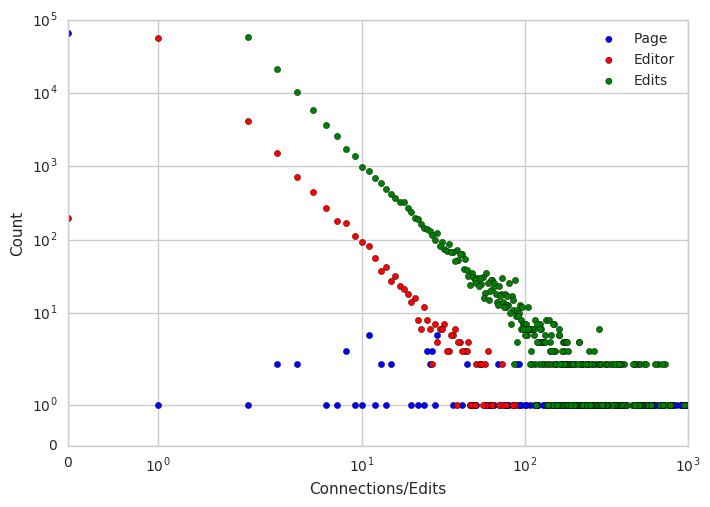

In [28]:
in_degree_dist_df = cg_degree_df['In'].value_counts().reset_index()
out_degree_dist_df = cg_degree_df['Out'].value_counts().reset_index()
revision_dist_df = collab_nobot_edgelist_df['edits'].value_counts().reset_index()

f,ax = plt.subplots(1,1)
in_degree_dist_df.plot.scatter(x='index',y='In',ax=ax,c='blue',label='Page')
out_degree_dist_df.plot.scatter(x='index',y='Out',ax=ax,c='red',label='Editor')
revision_dist_df.plot.scatter(x='index',y='edits',ax=ax,c='green',label='Edits')
ax.set_xlabel('Connections/Edits')
ax.set_ylabel('Count')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.set_xlim((0,1e3))
ax.set_ylim((0,1e5));

## Identify which pages share the most editors in common in the bipartite graph

There are several different ways to calculate clustering in a bipartite network. These all capture the tendency for pages to share editors in common: values closer to 0 imply that an article's editors have contributed to few articles in common and values closer to 1 imply that an article's editors share all articles in common. This definition can be expanded to account for the size of different networks' 

* **Dot** is the intersection of nodes divided by the union of nodes across all the node's neighbors.
* **Min** is the intersection of nodes divided by the smallest set of nodes across all the node's neighbors.
* **Max** is the intersection of nodes divided by the largest set of nodes across all the node's neighbors.

Figure 5 in Latapy, Magnien, & Del Vecchio (2008) provides another visualization:

![bipartite_clustering](http://i.imgur.com/MnLoO9Z.png)

Create a loop that computes each of these bipartite clustering values for the pages in the bipartite collaboration network.

In [30]:
collab_bp_ud = collab_nobot_g.to_undirected()
clustering_df = pd.DataFrame(index=collab_nobot_pages)
for mode in ['dot','min','max']:
    clustering_df[mode] = pd.Series(nx.bipartite.clustering(collab_bp_ud,nodes=collab_nobot_pages,mode=mode))

Look at what articles have the highest overlap with other articles based on sharing editors in common, according to each of the three definitions.

In [41]:
clustering_df['dot'].sort_values(ascending=False).head(10)

p:George_H._W._Bush                             0.017694
p:Laura_W._Bush_Institute_for_Women's_Health    0.016275
p:Al_Gore                                       0.016038
p:United_States_Congress                        0.015773
p:Laura_Bush                                    0.015732
p:Hillary_Clinton                               0.015621
p:John_F._Kennedy                               0.015560
p:Michelle_Obama                                0.015473
p:Ronald_Reagan                                 0.015463
p:Colorado                                      0.015206
Name: dot, dtype: float64

In [42]:
clustering_df['min'].sort_values(ascending=False).head(10)

p:Barbara_Bush_Foundation_for_Family_Literacy                            1.000000
p:US-Middle_East_Partnership_for_Breast_Cancer_Awareness_and_Research    0.500000
p:Laura_W._Bush_Institute_for_Women's_Health                             0.400000
p:Spoken_from_the_Heart                                                  0.333333
p:First_Ladies_Summit                                                    0.250000
p:Elie_Wiesel_Foundation_for_Humanity                                    0.250000
p:Houston_Public_Library                                                 0.181548
p:Order_of_Gabriela_Silang                                               0.166667
p:National_Heart,_Lung,_and_Blood_Institute                              0.161491
p:Flat_Rock,_Henderson_County,_North_Carolina                            0.156448
Name: min, dtype: float64

In [43]:
clustering_df['max'].sort_values(ascending=False).head(10)

p:George_H._W._Bush                     0.026424
p:Al_Gore                               0.024140
p:United_States_Congress                0.023561
p:Laura_Bush                            0.023467
p:Colorado                              0.023386
p:Supreme_Court_of_the_United_States    0.023109
p:California                            0.022869
p:Hillary_Clinton                       0.022839
p:Michelle_Obama                        0.022330
p:John_F._Kennedy                       0.022315
Name: max, dtype: float64

Plot the distribution of the clustering coefficients for the pages.

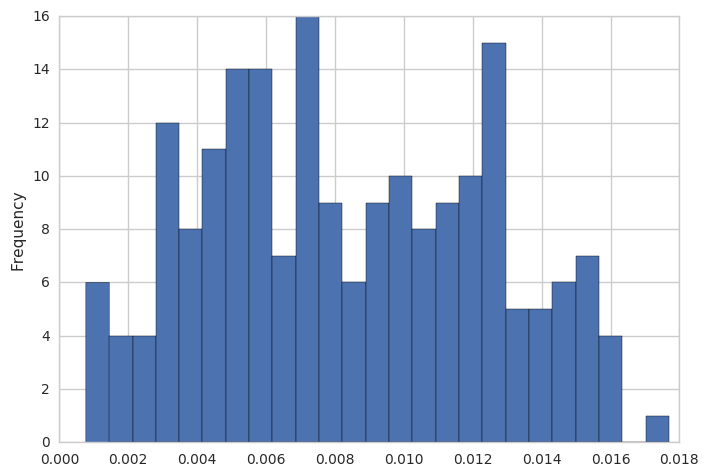

In [109]:
clustering_df['dot'].plot.hist(bins=25)

Because the distributions for these clustering values are so skewed, look at the median values to describe the network as a whole.

In [34]:
clustering_df['dot'].median(), clustering_df['min'].median(), clustering_df['max'].median()

(0.007760796532944082, 0.04985100323200635, 0.011069332824029728)

How is the clustering coefficient correlated with the connectivity of the node?

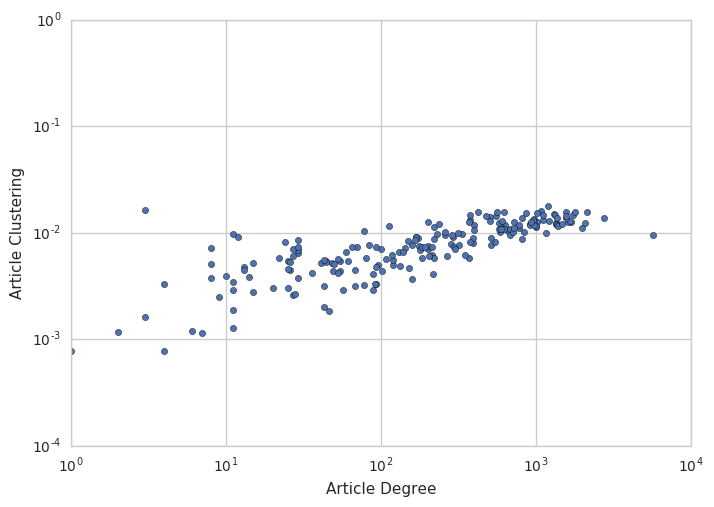

In [45]:
degree_clustering_df = pd.DataFrame({'Degree':cg_degree_df.query('Page')['In'],'Clustering':clustering_df['dot']})

ax = degree_clustering_df.plot.scatter(x='Degree',y='Clustering')
max_degree_rounded = np.round(degree_clustering_df['Degree'].max(),-4)
ax.set_xlabel('Article Degree')
ax.set_ylabel('Article Clustering')
ax.set_xlim((1,max_degree_rounded))
ax.set_ylim((1/max_degree_rounded,1e0))
ax.set_xscale('log')
ax.set_yscale('log')

## Measure neighbor connectivity in the bipartite graph

[Assortativity](https://en.wikipedia.org/wiki/Assortativity) is a complex network property measuring whether nodes are connected to other similar nodes. A related concept is called "[homophily](https://en.wikipedia.org/wiki/Homophily)".

Working from the degree analyses we did above, we can do a similar measure of "degree assortativity" that captures the tendency for well-connected nodes to be connected to other well-connected nodes. This is a property seen in many social networks where popular actors surround themselves with other popular actors. Conversely, in many natural systems "dissortative" patterns are observed wherein well-connected nodes are connected to poorly-connected nodes. One popular reason given for this difference is that many natural (as opposed to social) systems have evolved to be resilient and that separating well-connected nodes from poorly-connected nodes helps insulate the network from failures.

While assortativity is typically examined in the context of one-mode (e.g., page-page or user-user) networks, we can extend this definition to our bipartite collaboration network by looking at neighbor connectivity.

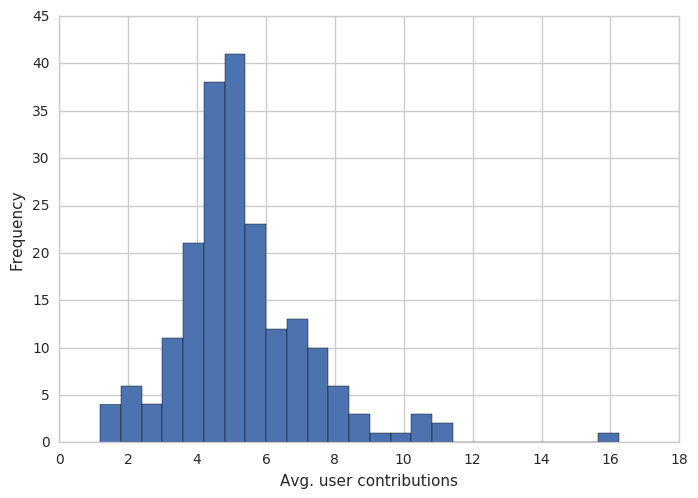

In [36]:
avg_page_neighbor_degree = nx.neighbor_degree.average_neighbor_degree(collab_bp_ud,
                                                                     source='in',target='out',
                                                                     nodes=collab_nobot_pages)

ax = pd.Series(avg_page_neighbor_degree).plot.hist(bins=25)
ax.set_xlabel('Avg. user contributions')

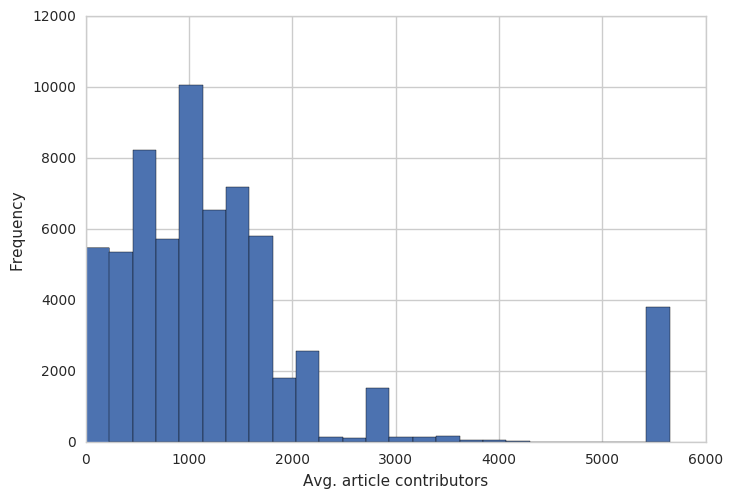

In [39]:
avg_user_neighbor_degree = nx.neighbor_degree.average_neighbor_degree(collab_bp_ud,
                                                                     source='in',target='out',
                                                                     nodes=collab_nobot_users)

ax = pd.Series(avg_user_neighbor_degree).plot.hist(bins=25)
ax.set_xlabel('Avg. article contributors')

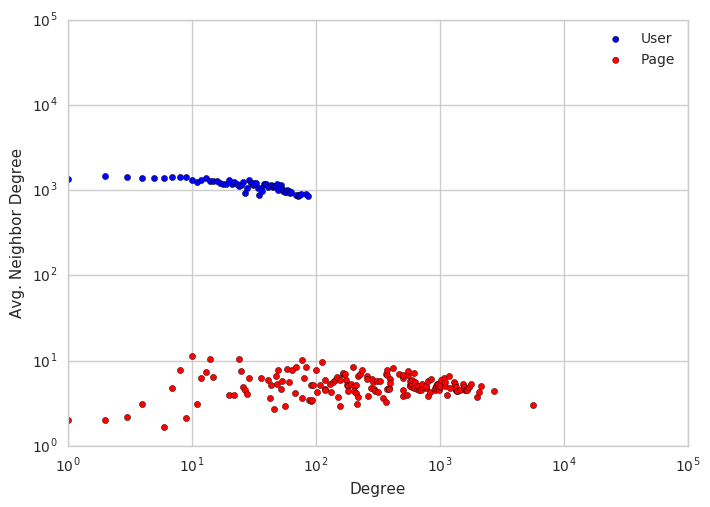

In [88]:
# Compute the average degree connectivity for users
page_collab_avg_connectivity = nx.assortativity.average_degree_connectivity(collab_bp_ud,
                                                                     source='in',target='out',
                                                                     nodes=collab_nobot_users)
# Compute the average degree connectivity for pages
user_collab_avg_connectivity = nx.assortativity.average_degree_connectivity(collab_bp_ud,
                                                                     source='out',target='in',
                                                                     nodes=collab_nobot_pages)
# Combine into a DataFrame and cleanup
collab_avg_connectivity_df = pd.DataFrame({'Page':page_collab_avg_connectivity,'User':user_collab_avg_connectivity})
collab_avg_connectivity_df = collab_avg_connectivity_df.reset_index()
collab_avg_connectivity_df = collab_avg_connectivity_df.rename(columns={'index':'Connections'})

# Plot the data
ax = collab_avg_connectivity_df.plot.scatter(x='Connections',y='Page',label='User',c='blue')
ax = collab_avg_connectivity_df.plot.scatter(x='Connections',y='User',ax=ax,label='Page',c='red')
ax.set_xlim((1e0,1e5))
ax.set_ylim((1e0,1e5))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('Avg. Neighbor Degree')

## Compute descriptive statistics for the projected graph

In [46]:
nx.density(page_collaboration_g)

0.5074371859296483

Compute the degree centrality of the nodes in the projected graph.

In [103]:
page_collab_size = page_collaboration_g.number_of_nodes()
page_collab_dc = {node:round(degree*(page_collab_size - 1),0) for node,degree in nx.degree_centrality(page_collaboration_g).items()}

pd.Series(page_collab_dc).sort_values(ascending=False).head(10)

p:George_W._Bush       177.0
p:Ronald_Reagan        174.0
p:Barack_Obama         173.0
p:George_H._W._Bush    171.0
p:Hillary_Clinton      169.0
p:John_F._Kennedy      167.0
p:Donald_Trump         167.0
p:Texas                166.0
p:Dallas               166.0
p:California           165.0
dtype: float64

Compute the clustering of the nodes in the projected graph.

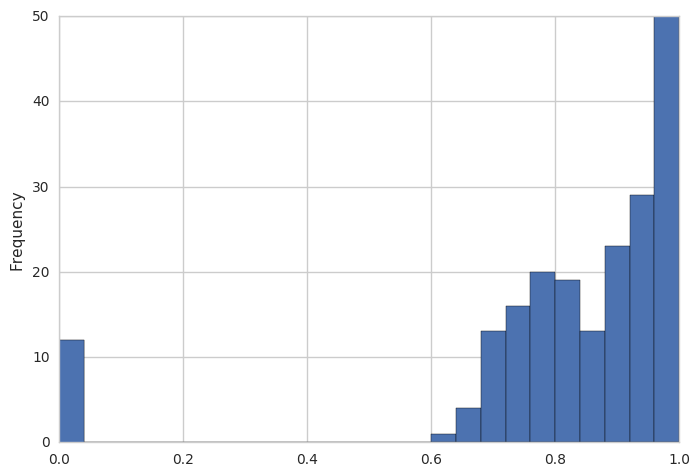

In [101]:
page_collab_clustering = nx.clustering(page_collaboration_g)

pd.Series(page_collab_clustering).plot.hist(bins=25)

Plot the clustering against degree.

(0, 1.05)

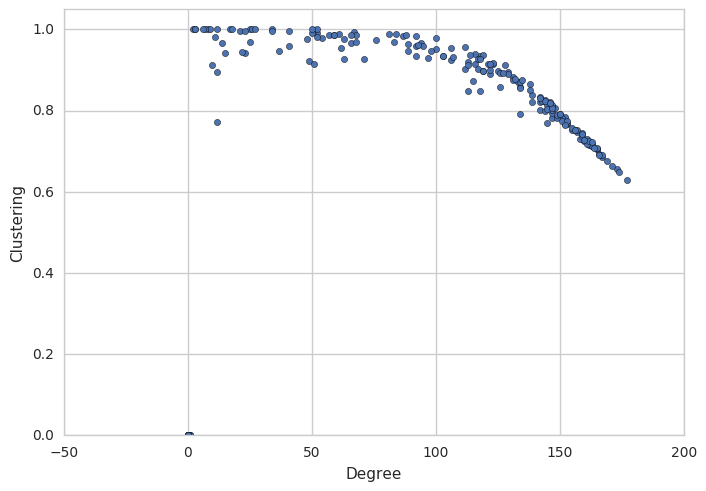

In [108]:
page_collab_degree_clustering_df = pd.DataFrame({'Clustering':page_collab_clustering,'Degree':page_collab_dc})

ax = page_collab_degree_clustering_df.plot.scatter(x='Degree',y='Clustering')
ax.set_ylim((0,1.05))

Compute the average neighbor degrees in the projected graph and plot the degree vs. avg. neighbor degree.

(0, 300.0)

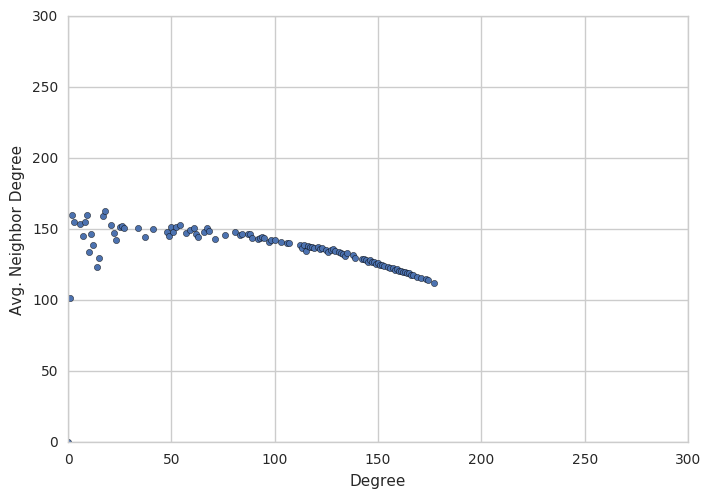

In [97]:
page_collab_avg_connectivity = nx.assortativity.average_degree_connectivity(page_collaboration_g)

_df = pd.Series(page_collab_avg_connectivity).reset_index().rename(columns={'index':'Degree',0:'Avg. Neighbor Degree'})
ax = _df.plot.scatter(x='Degree',y='Avg. Neighbor Degree')
_max = round(len(page_collaboration_g),-2)*1.5
ax.set_xlim((0,_max))
ax.set_ylim((0,_max))

## Comparing the hyperlink and coauthorship projected networks